<a href="https://colab.research.google.com/github/Ari0307/BarTracker/blob/master/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

<h1>Welcome to Colaboratory!</h1>


Colaboratory is a free Jupyter notebook environment that requires no setup and runs entirely in the cloud.

With Colaboratory you can write and execute code, save and share your analyses, and access powerful computing resources, all for free from your browser.

Automatically created module for IPython interactive environment


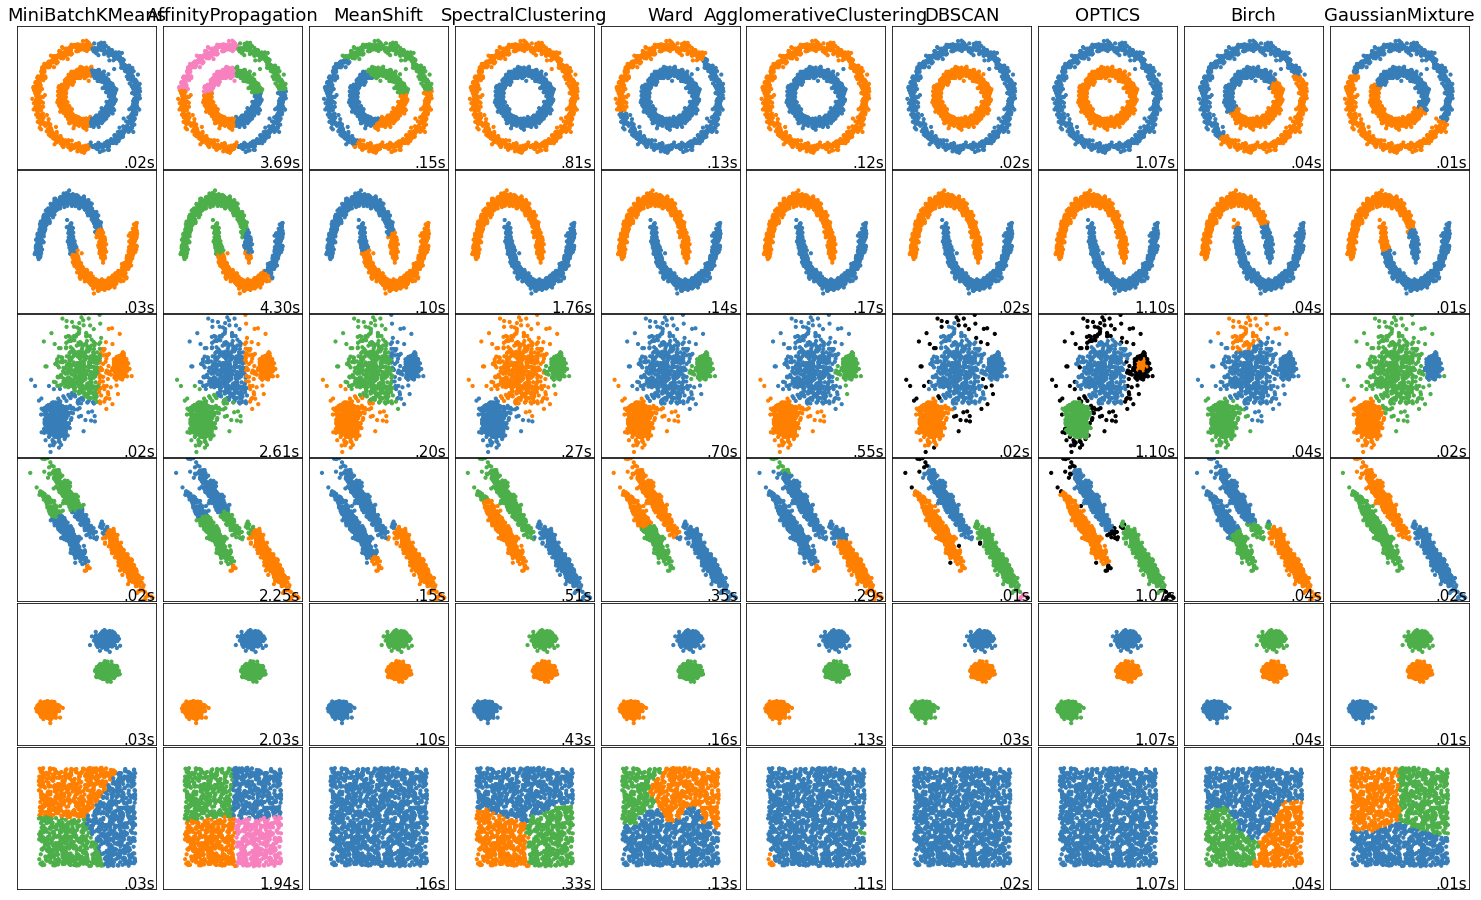

In [1]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()


In [0]:
#@title Introducing Colaboratory { display-mode: "form" }
#@markdown This 3-minute video gives an overview of the key features of Colaboratory:
from IPython.display import YouTubeVideo
YouTubeVideo('inN8seMm7UI', width=600, height=400)

## Getting Started

The document you are reading is a  [Jupyter notebook](https://jupyter.org/), hosted in Colaboratory. It is not a static page, but an interactive environment that lets you write and execute code in Python and other languages.

For example, here is a **code cell** with a short Python script that computes a value, stores it in a variable, and prints the result:

In [0]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

To execute the code in the above cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Command/Ctrl+Enter".

All cells modify the same global state, so variables that you define by executing a cell can be used in other cells:

In [0]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

For more information about working with Colaboratory notebooks, see [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb).


## More Resources

Learn how to make the most of Python, Jupyter, Colaboratory, and related tools with these resources:

### Working with Notebooks in Colaboratory
- [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)
- <img src="/img/new.png" height="20px" align="left" hspace="4px" alt="New"></img>
 [TensorFlow 2 in Colab](/notebooks/tensorflow_version.ipynb)

### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb) 
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas](/notebooks/mlcc/intro_to_pandas.ipynb)
- [Tensorflow concepts](/notebooks/mlcc/tensorflow_programming_concepts.ipynb)
- [First steps with TensorFlow](/notebooks/mlcc/first_steps_with_tensor_flow.ipynb)
- [Intro to neural nets](/notebooks/mlcc/intro_to_neural_nets.ipynb)
- [Intro to sparse data and embeddings](/notebooks/mlcc/intro_to_sparse_data_and_embeddings.ipynb)

### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TensorFlow with TPUs](/notebooks/tpu.ipynb)

## Machine Learning Examples: Seedbank

To see end-to-end examples of the interactive machine learning analyses that Colaboratory makes possible, check out the [Seedbank](https://research.google.com/seedbank/) project.

A few featured examples:

- [Neural Style Transfer](https://research.google.com/seedbank/seed/neural_style_transfer_with_tfkeras): Use deep learning to transfer style between images.
- [EZ NSynth](https://research.google.com/seedbank/seed/ez_nsynth): Synthesize audio with WaveNet auto-encoders.
- [Fashion MNIST with Keras and TPUs](https://research.google.com/seedbank/seed/fashion_mnist_with_keras_and_tpus): Classify fashion-related images with deep learning.
- [DeepDream](https://research.google.com/seedbank/seed/deepdream): Produce DeepDream images from your own photos.
- [Convolutional VAE](https://research.google.com/seedbank/seed/convolutional_vae): Create a generative model of handwritten digits.